<a href="https://colab.research.google.com/github/phonhay103/anything/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

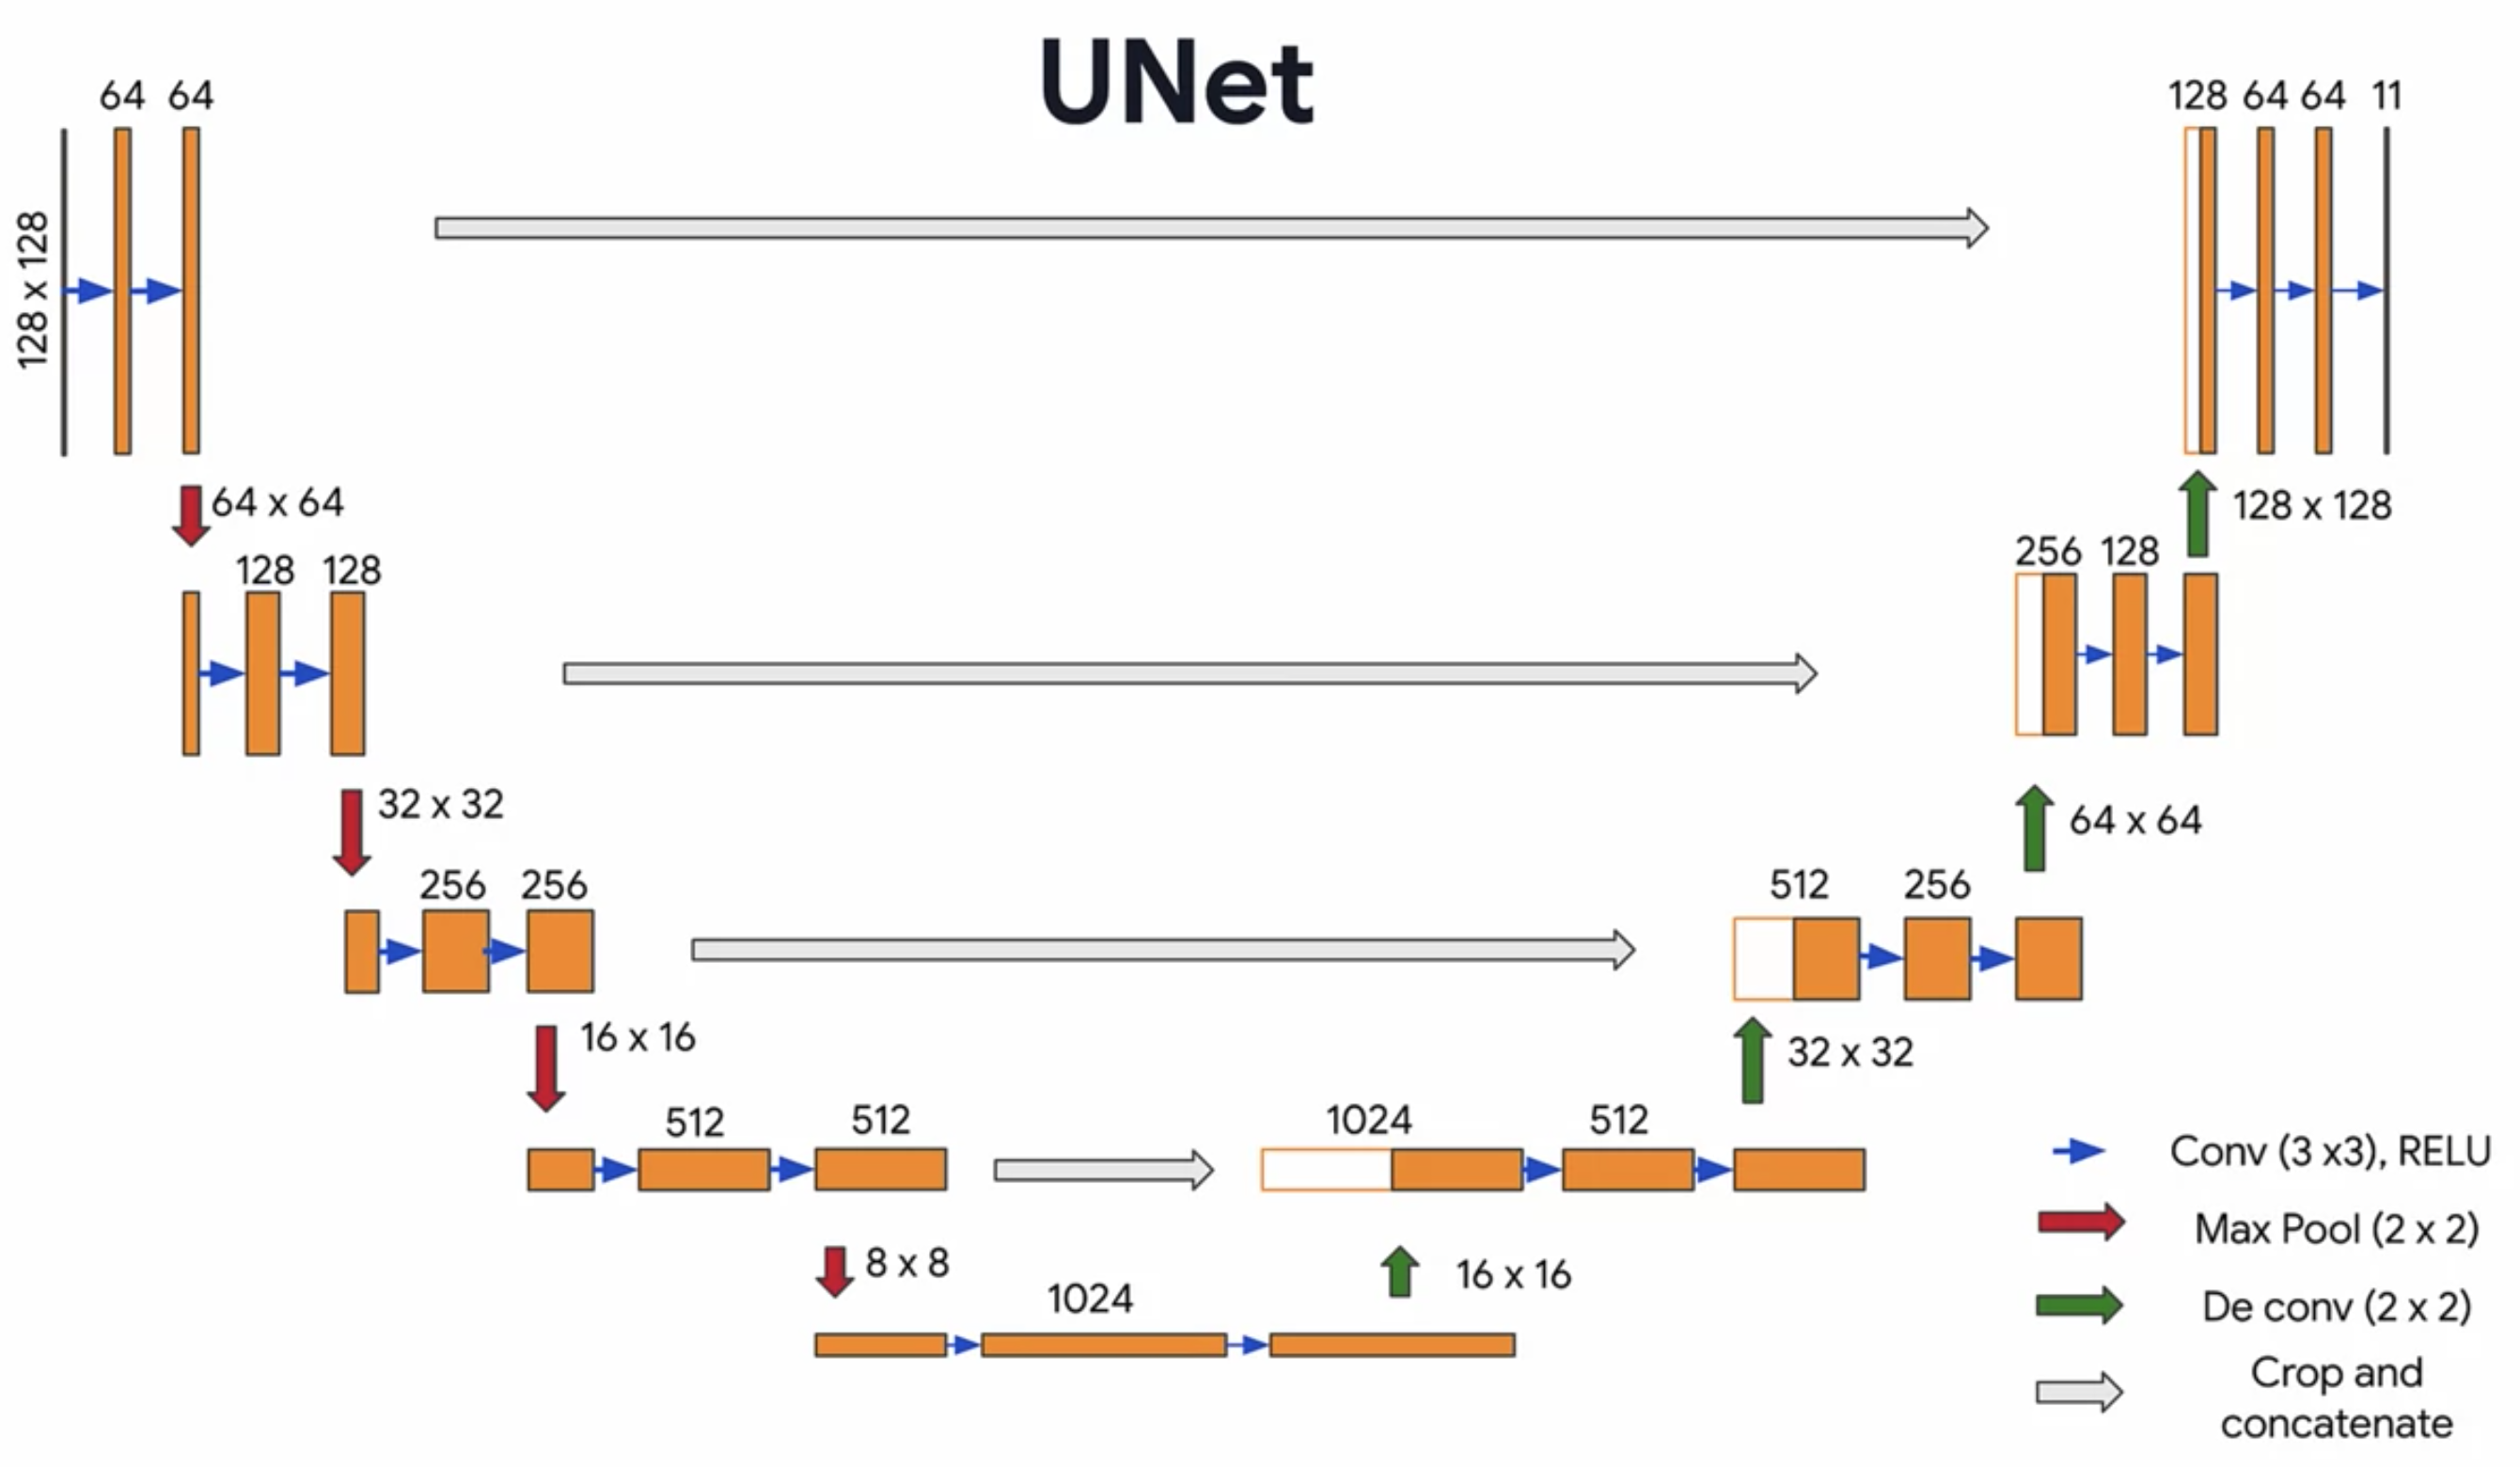

In [1]:
import tensorflow as tf

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size):
    '''
    Adds 2 convolutional layers with the parameters passed to it

    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution

    Returns:
        tensor of output features
    '''

    x = input_tensor
    x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding='same', activation='relu')(x)
    return x

In [6]:
def encoder_block(input_tensor, n_filters, kernel_size=3, dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.

    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution

    Returns:
        x - the output features of the convolution block 
        y - the maxpooled features with dropout
    '''
    x = conv2d_block(input_tensor, n_filters, kernel_size)
    y = tf.keras.layers.MaxPooling2D()(x)
    y = tf.keras.layers.Dropout(dropout)(y)
    return x, y

def encoder(input_tensor):
    '''
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    (x1, x2, x3, x4) - the output features of all the encoder blocks
    y - the output maxpooled features of the last encoder block
    '''

    x1, y = encoder_block(input_tensor, 64)
    x2, y = encoder_block(y, 128)
    x3, y = encoder_block(y, 256)
    x4, y = encoder_block(y, 512)
    return (x1, x2, x3, x4), y

In [26]:
def bottleneck(input_tensor):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''

    return conv2d_block(input_tensor, 1024, 3)

In [55]:
def decoder_block(input_tensor, conv_output, n_filters, kernel_size, dropout=0.3):
    x = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=2, padding='same')(input_tensor)
    x = tf.keras.layers.concatenate([x, conv_output])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = conv2d_block(x, n_filters, kernel_size=3)
    return x

def decoder(input_tensor, convs, n_classes):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 
    
    Args:
        input_tensor -- batch of input features
        convs (tuple) -- features from the encoder blocks
        n_classes (int) -- number of classes in the label map

    Returns:
        outputs (tensor) -- the pixel wise label map of the image
    '''

    x = decoder_block(input_tensor, convs[3], 512, kernel_size=3)
    x = decoder_block(x, convs[2], n_filters=256, kernel_size=3)
    x = decoder_block(x, convs[1], n_filters=128, kernel_size=3)
    x = decoder_block(x, convs[0], n_filters=64, kernel_size=3)
    x = tf.keras.layers.Conv2D(n_classes, kernel_size=1, activation='softmax')(x)

    return x

In [73]:
class Unet(tf.keras.Model):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder

    def call(self, inputs):
        convs, encoder_output = self.encoder(inputs)
        bottle_neck = self.bottleneck(encoder_output)
        outputs = self.decoder(bottle_neck, convs, self.n_classes)
        return outputs

In [81]:
n_classes = 3
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
convs, encoder_output = encoder(inputs)
bottle_neck = bottleneck(encoder_output)
outputs = decoder(bottle_neck, convs, n_classes)
model = tf.keras.Model(inputs=inputs, outputs=outputs)